In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
from sklearn.base import BaseEstimator, RegressorMixin
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.datasets import fetch_california_housing
from scikeras.wrappers import KerasRegressor
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error
import shap
from sklearn.inspection import permutation_importance
from PyALE import ale
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import r2_score

c:\UoM\Year 3\ARI3205 Interpretable AI for DL Models\interpretableaiproject\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
housing = fetch_california_housing()

X = housing.data
y = housing.target

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print("\nFeature names:")
print(housing.feature_names)

Features (X) shape: (20640, 8)
Target (y) shape: (20640,)

Feature names:
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


# Part 1: Feature-Level Interpretability (30 marks)  
You will use the California Housing and the Adult Census Income datasets in this part. You 
should train one feed-forward neural network for each dataset and apply the following 
interpretability techniques:

In [2]:

# Load and preprocess the Adult Census Income dataset
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]

train_adult = pd.read_csv(
    "DataSets/census/adult.data", header=None, names=columns, sep=",",
    na_values=" ?", skipinitialspace=True
)
test_adult = pd.read_csv(
    "DataSets/census/adult.test", header=0, names=columns, sep=",",
    na_values=" ?", skipinitialspace=True, comment="|"
)
test_adult["income"] = test_adult["income"].str.replace(".", "", regex=False)

data_adult = pd.concat([train_adult, test_adult], ignore_index=True).dropna()

X_adult = data_adult.drop("income", axis=1)
y_adult = (data_adult["income"] == ">50K").astype(int)

# Keep a copy of raw features for LIME
X_adult_raw = X_adult.copy()
y_adult_raw = y_adult.copy()


cat_cols = X_adult.select_dtypes(include=["object"]).columns
num_cols = X_adult.select_dtypes(exclude=["object"]).columns

# Split raw data for LIME
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_adult_raw, y_adult_raw, test_size=0.2, random_state=42
)

ct = ColumnTransformer([
    ("onehot", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("scale", StandardScaler(), num_cols)
])

X_processed = ct.fit_transform(X_adult)
X_train_adult, X_test_adult, y_train_adult, y_test_adult = train_test_split(
    X_processed, y_adult, test_size=0.2, random_state=42
)

print(f"Training samples: {X_train_adult.shape[0]} | Test samples: {X_test_adult.shape[0]}")
# Build the Keras Model to be used with scikeras
def create_model():
    model = keras.Sequential([
        layers.Dense(128, activation="relu", input_shape=(X_train_adult.shape[1],)),
        layers.Dropout(0.3),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = KerasClassifier(
    model=create_model,
    epochs=10,
    batch_size=256,
    verbose=1
)

print("--- Starting Model Training ---")
history = model.fit(X_train_adult, y_train_adult, validation_split=0.2)
print("--- Training Complete ---")

# Evaluate on test data
test_loss, test_acc = model.model_.evaluate(X_test_adult, y_test_adult, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

Training samples: 39072 | Test samples: 9769
--- Starting Model Training ---


c:\UoM\Year 3\ARI3205 Interpretable AI for DL Models\interpretableaiproject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8228 - loss: 0.3809 - val_accuracy: 0.8522 - val_loss: 0.3195
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8497 - loss: 0.3241 - val_accuracy: 0.8534 - val_loss: 0.3119
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8528 - loss: 0.3173 - val_accuracy: 0.8577 - val_loss: 0.3096
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8550 - loss: 0.3130 - val_accuracy: 0.8571 - val_loss: 0.3098
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8572 - loss: 0.3090 - val_accuracy: 0.8581 - val_loss: 0.3102
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8576 - loss: 0.3083 - val_accuracy: 0.8582 - val_loss: 0.3081
Epoch 7/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8584 - loss: 0.3061 - val_accuracy: 0.8585 - val_loss: 0.3095
Epoch 8/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8604 - loss: 0.3044 - val_accuracy: 0.

In [9]:
# California Housing Dataset pre-processing and neural network model

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

print(f"Total data points: {len(X)}")
print(f"Training data points: {len(X_train)}")
print(f"Validation data points: {len(X_valid)}")
print(f"Test data points: {len(X_test)}")


scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

print("Data successfully scaled")
print(f"Original mean (first feature): {X_train[:, 0].mean():.4f}")
print(f"Scaled mean (first feature): {X_train_scaled[:, 0].mean():.4f}")


def create_model():

    n_features = X_train_scaled.shape[1]

    model = keras.Sequential([
        layers.Dense(64, activation="relu", input_shape=[X_train_scaled.shape[1]]),
        layers.Dropout(0.2),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(16, activation="relu"),
        layers.Dense(1)
    ])
    
    model.compile(
        loss="mean_squared_error",
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        metrics=["mean_absolute_error"]
    )
    
    return model

model = KerasRegressor(
    model=create_model,
    verbose=0
)

print("Keras Wrapper created successfully")

print("Model compiled with MSE as the loss function and Dropout Layers and a custom Adam.")

print("--- Starting Model Training ---")

early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_valid_scaled, y_valid),
    callbacks=[early_stopping],
    verbose=1
)

print("--- Model Training Finished ---")

print("--- Evaluating Model on Test Set ---")

y_pred = model.predict(X_test_scaled)

final_mse = mean_squared_error(y_test, y_pred)
final_mae = mean_absolute_error(y_test, y_pred)

print(f"Final Test Set MSE (Mean Squared Error): {final_mse:.4f}")
print(f"Final Test Set MAE (Mean Absolute Error): {final_mae:.4f}")

Total data points: 20640
Training data points: 13209
Validation data points: 3303
Test data points: 4128
Data successfully scaled
Original mean (first feature): 3.8689
Scaled mean (first feature): -0.0000
Keras Wrapper created successfully
Model compiled with MSE as the loss function and Dropout Layers and a custom Adam.
--- Starting Model Training ---
Epoch 1/100


c:\Users\jamie\OneDrive\Desktop\Interpretable AI Project\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 2.0401 - mean_absolute_error: 1.0091 - val_loss: 0.6080 - val_mean_absolute_error: 0.5133
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6048 - mean_absolute_error: 0.5563 - val_loss: 0.4454 - val_mean_absolute_error: 0.4620
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5253 - mean_absolute_error: 0.5198 - val_loss: 0.4064 - val_mean_absolute_error: 0.4544
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4757 - mean_absolute_error: 0.4914 - val_loss: 0.4130 - val_mean_absolute_error: 0.4466
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4442 - mean_absolute_error: 0.4784 - val_loss: 0.3961 - val_mean_absolute_error: 0.4441
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4231 - mean_absolute_error: 0.4566 - val_loss: 0.3782 - val_mean_absolute_error: 0.4298
Epoch 7/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4186 - mean_absolute_error: 0.4595 - val_lo

## 1. Partial Dependence Plots (PDP) and Individual Conditional Expectation (ICE) plots (7 marks) 
### a. Use PDP to examine the average effect of at least two features. 

Found 108 processed features.

Calculating and plotting for 'scale__age'...
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━

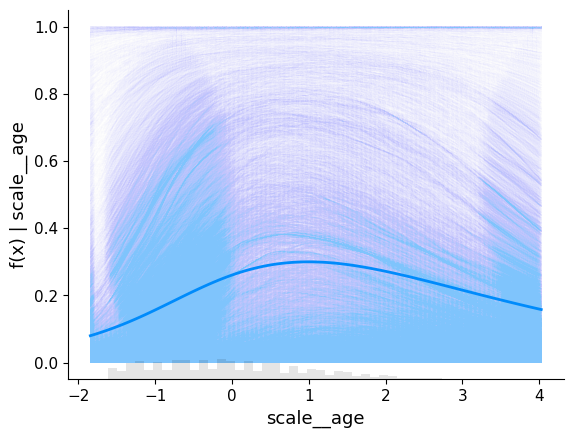


Calculating and plotting for 'scale__hours-per-week'...
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1221/1221 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/st

KeyboardInterrupt: 

In [5]:
actual_keras_model = model.model_

full_feature_names = ct.get_feature_names_out()
print(f"Found {len(full_feature_names)} processed features.")

X_train_df = pd.DataFrame(X_train_adult.toarray(), columns=full_feature_names)

predict_fn = lambda X: actual_keras_model.predict(X).ravel()

features_to_plot = ["scale__age", "scale__hours-per-week"]

for feature in features_to_plot:
    print(f"\nCalculating and plotting for '{feature}'...")
    shap.plots.partial_dependence(
        feature,
        predict_fn,
        X_train_df,
        show=True
    )


Calculating and plotting PDP for 'MedInc'...
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

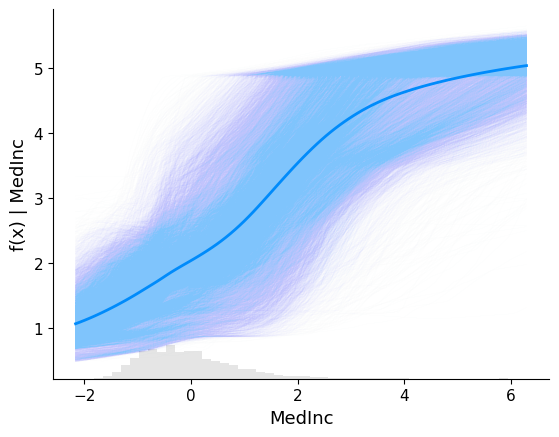


Calculating and plotting PDP for 'HouseAge'...
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
413/413 ━━━━━━━━━━━━━━━━━━━━ 1

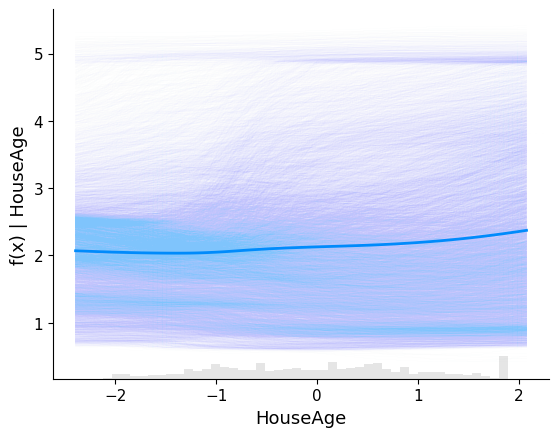

In [11]:
# California Housing

actual_keras_model = model.model_

original_feature_names = housing.feature_names

predict_fn = lambda X: actual_keras_model.predict(X).ravel()

print("\nCalculating and plotting PDP for 'MedInc'...")
shap.plots.partial_dependence(
    "MedInc",
    predict_fn,
    X_train_scaled,
    feature_names=original_feature_names,
    show=True
)

print("\nCalculating and plotting PDP for 'HouseAge'...")
shap.plots.partial_dependence(
    "HouseAge",
    predict_fn,
    X_train_scaled,
    feature_names=original_feature_names,
    show=True
)

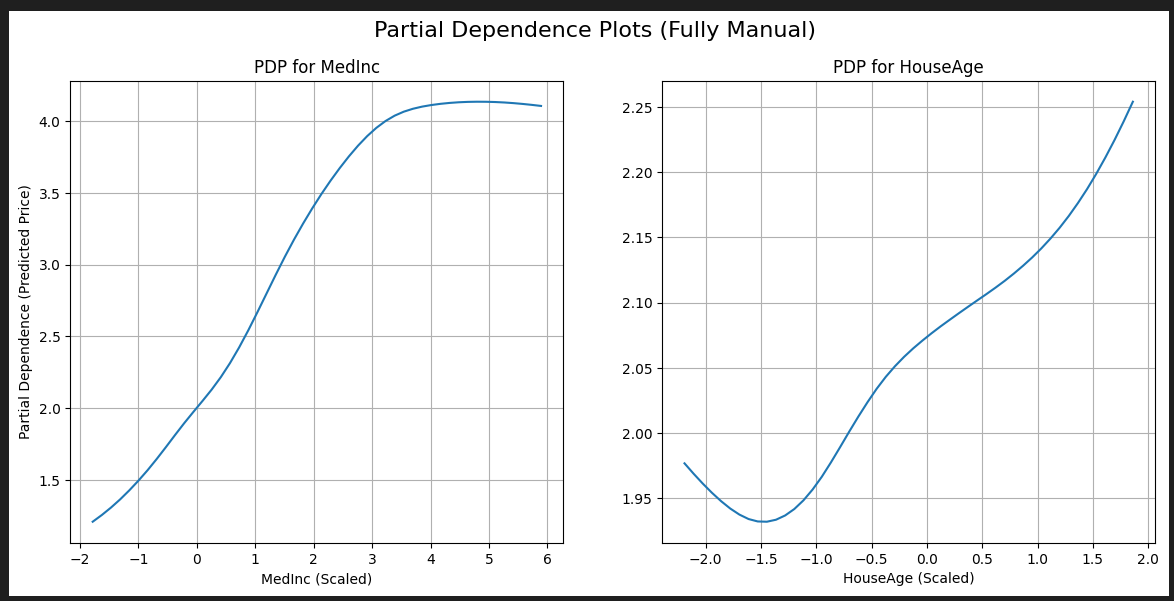

### b. Use ICE plots to explore individual predictions for at least two features. 

In [ ]:
#ICE and PDP for Adult Census Income Dataset are implemented together in the previous Task.

In [ ]:
#ICE and PDP for California Housing are implemented together in the previous Task

### c. Explain what insights PDP and ICE give about the model’s behaviour.

#### Adult Census Income Dataset

PDP: the graphs show the average trend, revealing that the model learned a logical tendency for career in relation to age. The average probability of earning >50K rises steadily, peaks in late-middle age, and then declines likely heading to retirement. Similarly, the PDP for hours-per-week shows that the probability increases most when moving from part-time to a standard 40-hour week, but then plateaus, indicating that the model learned working excessive hours provides diminishing returns on average.

ICE: however ICE plots show that these average trends are misleading. For both features, the faint individual lines are extremely spread out showing that the model's rule is not homogeneous, which is the most important insight. This means the model has learned a complex and conditional logic, where the effect of age or hours-per-week on any single person's income probability is heavily dependent on their other features.

#### California Housing Dataset

PDP:
- Median Income (MedInc): the plots illustrate a strong positive relationship between the predicted prices and MedInc. Which is also showing non-linear dependance, it rises steeply at first and then plateaus at higher income. Meaning the model has learned that after a certain point more income does not lead to much higher price prediction.
- HouseAge: the graphs show a complex "J" shaped relationship, predicting the lowest prices for houses that are slightly newer than average. Also, it predicts higher prices for both brand new and very old houses. Meaning the model learned two seperate patterns, new and old houses that manage to be sold at a high price.


ICE:
- MedInc: the graph clearly shows that the vast majority of faint blue-purple lines are tightly packed around the main blue PDP line. It indicates that the model's rule is homogeneous and it is applied in almost exact way to every house regardless other features.
- HouseAge: the faint lines are spread all across the range from 1 to 5, signifying that the effect of HouseAge is different for distinct houses. 

## 2. Permutation Feature Importance (PFI) (7 marks) 
### a. Use PFI to identify the most important features in the model. 


Feature		 | Importance (Drop in R-squared)
----------------------------------------
Population	 | 0.0136
AveBedrms 	 | 0.0422
HouseAge  	 | 0.0713
AveRooms  	 | 0.0761
AveOccup  	 | 0.2107
MedInc    	 | 0.5770
Longitude 	 | 0.6211
Latitude  	 | 0.6637


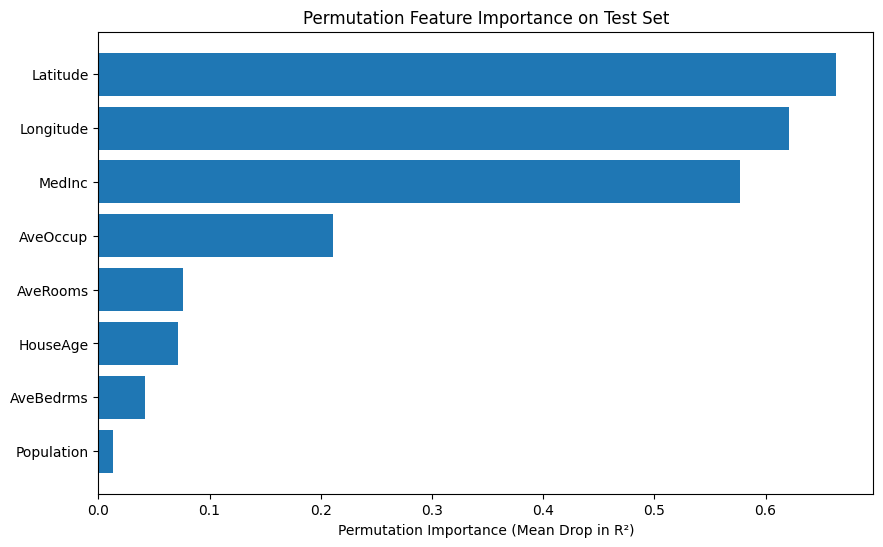

In [13]:
# California Housing Dataset

original_feature_names = housing.feature_names

pfi_results = permutation_importance(
    model,
    X_test_scaled,
    y_test,
    n_repeats=10,
    random_state=42,
)

sorted_indices = pfi_results.importances_mean.argsort()

print("Feature\t\t | Importance (Drop in R-squared)")
print("-" * 40)
for i in sorted_indices:
    print(f"{original_feature_names[i]:<10}\t | {pfi_results.importances_mean[i]:.4f}")

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(
    np.array(original_feature_names)[sorted_indices],
    pfi_results.importances_mean[sorted_indices]
)
ax.set_xlabel("Permutation Importance (Mean Drop in R²)")
ax.set_title("Permutation Feature Importance on Test Set")
plt.show()

### b. Explain what the term “important” means when using the PFI method. 

When using the PFI method, the term "important" means how much the model's performance and its accuracy depend on a specific feature.
It is measured by looking at how much the model's prediction error increases when the data for that certain feature is randomly shuffled.

## 3. Accumulated Local Effects (ALE) (9 marks) 
### a. Implement ALE plots to investigate the local effects of feature changes. 

PyALE._ALE_generic:INFO: Continuous feature detected.


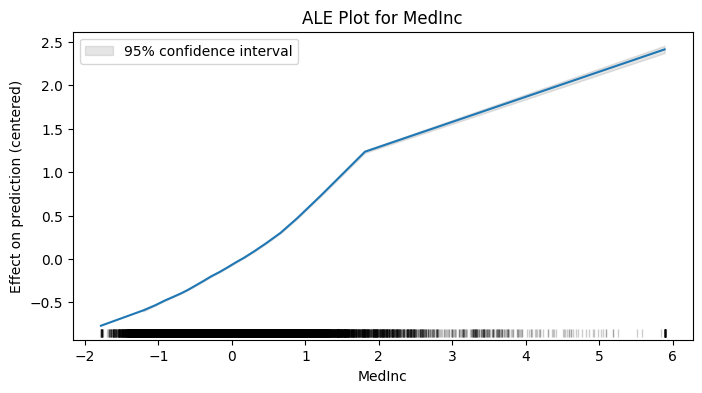

PyALE._ALE_generic:INFO: Continuous feature detected.


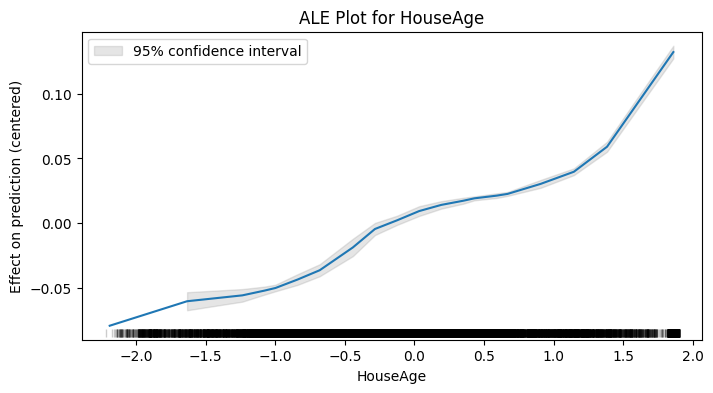

In [14]:
# California Housing Dataset

original_feature_names = housing.feature_names

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=original_feature_names)

ale_plot_medinc = ale(
    X=X_train_scaled_df,
    model=model,
    feature=["MedInc"],
    plot=True
)
plt.title("ALE Plot for MedInc")
plt.show()

ale_plot_houseage = ale(
    X=X_train_scaled_df,
    model=model,
    feature=["HouseAge"],
    plot=True
)
plt.title("ALE Plot for HouseAge")
plt.show()

### b. Compare ALE with PDP and discuss any differences in the interpretability of these techniques.

California Housing

PDP seems to be simpler, e.g., to see the effect of MedInc, it takes a single value and forces all the house samples in the dataset to have this value, while keeping other features the same. Concequently, thiss might create unrealistic data, like a house with rural location, low income area, and have a MedInc as rich. While ALE acts smarter and safer, avoiding creating unreal data scenarios. It divides the feature into small parts and only looks at real houses in that specific part. It calculates the change in prediction just for those houses and then adds up these local changes across the whole feature.

However, in our case the graphs show similarity in both PDP and ALE. PDP for MedInc shows a steep rise and then plateauing the same as ALE, and even for HouseAge PDP illustrates a dip followed by a steep rise, exactly the same as ALE. Which signifies that even though PDP might be misleading, in this situation, the relationship between MedInc, HouseAge, and other features is not strong enough to significantly influence PDP.

## 4. Global Surrogates (7 marks) 
### a. Build an interpretable model to approximate the predictions of the feed-forward neural network model. 

R-squared (Fidelity): 0.6989


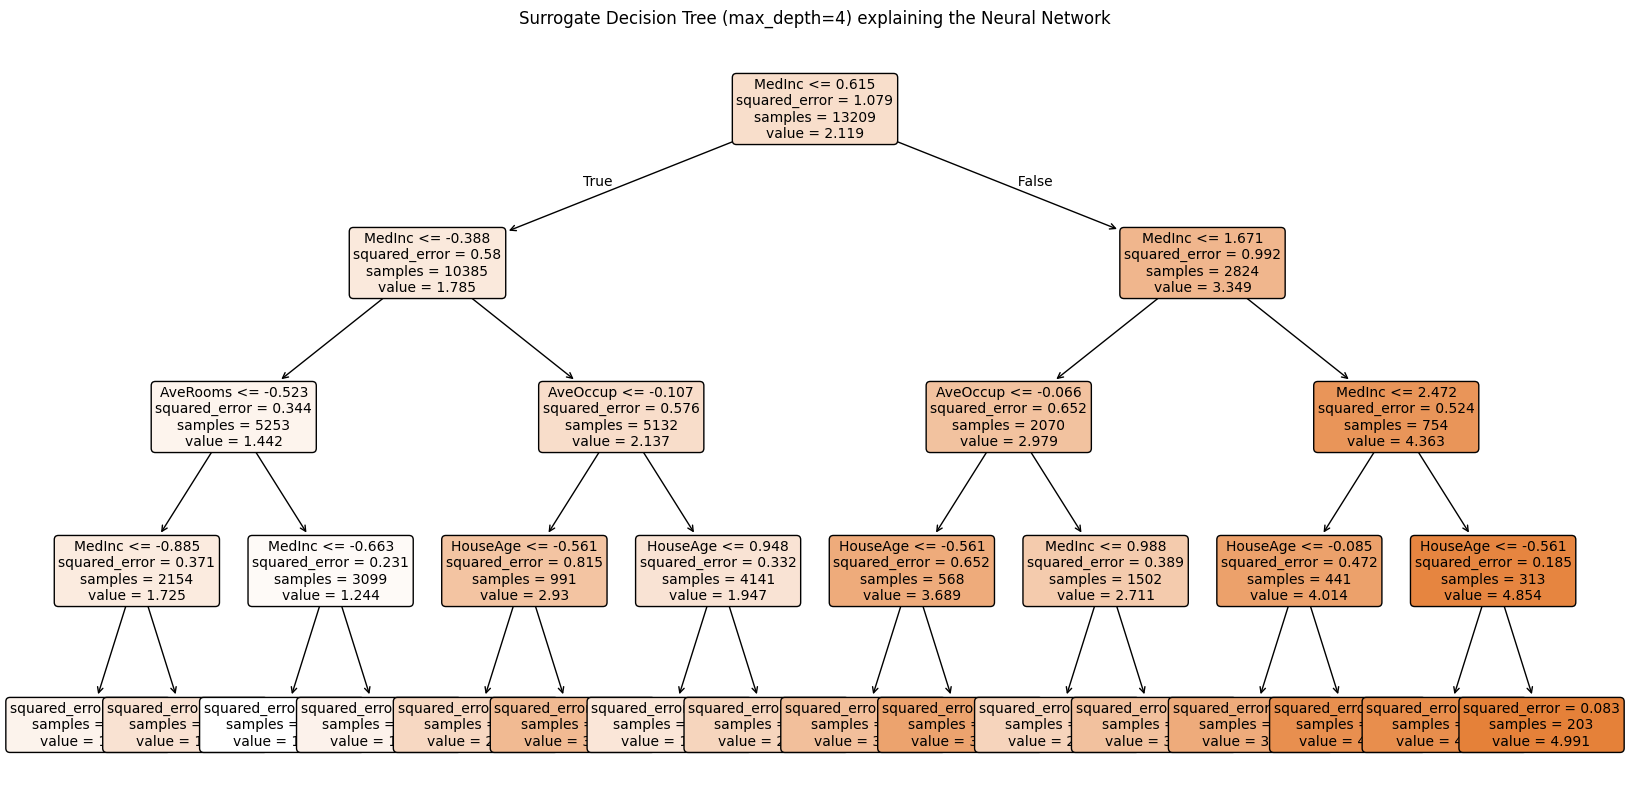

In [15]:
# California Housing Dataset

nn_predictions_train = model.predict(X_train_scaled)

surrogate_model = DecisionTreeRegressor(max_depth=4, random_state=42)

surrogate_model.fit(X_train_scaled, nn_predictions_train)

nn_predictions_test = model.predict(X_test_scaled)
surrogate_predictions_test = surrogate_model.predict(X_test_scaled)

fidelity_r2 = r2_score(nn_predictions_test, surrogate_predictions_test)

print(f"R-squared (Fidelity): {fidelity_r2:.4f}")

original_feature_names = housing.feature_names
plt.figure(figsize=(20, 10))
plot_tree(
    surrogate_model,
    feature_names=original_feature_names,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Surrogate Decision Tree (max_depth=4) explaining the Neural Network")
plt.show()

### b. Analyse the surrogate model's effectiveness and discuss when such approximations are helpful.

The Global Surrogate model's R-squared score of 0.6848 indicates a moderate fidelity. A simple, 4-level deep desicion tree was chosen as a surrogate model, which managed to explain 68.5% of the neural network's logic. This decent score shows that the neural network has learned quite a complex and non-linear set of rules that cannot be perfectly captured in a simple and interpretable model. Generally, the use of Global Surrogate models can be very helpful when we need to explain a black box model such as various neural networks and other architectures. Which makes the model be more understandable and easy to interpret.

# Part 2: Local Interpretability Techniques (30 marks)  
You will use the Adult Census Income dataset in this part. You should use the feed-forward 
neural network you trained in Part 1 and apply the following interpretability techniques: 

## 1. Local Interpretable Model-agnostic Explanations (LIME) (10 marks) 
### a. Apply LIME to explain individual predictions from the feed-forward neural network model. 

 


In [ ]:
from lime.lime_tabular import LimeTabularExplainer

# Use preprocessed X_train for LIME
X_train_lime_preprocessed = ct.transform(X_train_raw)
X_test_lime_preprocessed = ct.transform(X_test_raw)

explainer = LimeTabularExplainer(
    training_data=X_train_lime_preprocessed,
    feature_names=ct.get_feature_names_out(),  # optional
    class_names=["<=50K", ">50K"],
    mode="classification",
    discretize_continuous=False,
    random_state=42
)

# Prediction function now is just the model
def predict_fn_preprocessed(x):
    return np.hstack((1 - model.model_.predict(x), model.model_.predict(x)))

# Explain
exp = explainer.explain_instance(X_test_lime_preprocessed[sample_index], 
                                 predict_fn_preprocessed, 
                                 num_features=10)



ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_3" is incompatible with the layer: expected axis -1 of input shape to have value 8, but received input with shape (32, 108)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 108), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

### b. Explain how LIME approximates the local decision boundary and what the interpretation suggests. 


## 2. Shapley Additive Explanations (SHAP) (10 marks) 
### a. Use SHAP values to explain model predictions. 

 


### b. Compare SHAP explanations with LIME and discuss any differences between the two. 

## 3. Anchors (10 marks) 
### a. Implement Anchors to interpret model predictions for specific cases. 


### b. Compare Anchors with LIME and SHAP, and discuss any differences between them. 